In [258]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [259]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [260]:
path = untar_data(URLs.MNIST_SAMPLE)

In [261]:
#hide
Path.BASE_PATH = path

In [262]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [263]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [264]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes #sorted paths to 3 number images

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [265]:
im3_path = threes[1]
im3 = Image.open(im3_path) #show one image in dataset.
im3 #Image class from PIL (Python Imaging Library)

In [266]:
array(im3)[4:10,4:10] #part of image converted to NumPy array or PyTorch tensor.
#4:10 => rows from [4-10) index 10 not included. same for columns.

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [267]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [268]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [269]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)


> note: List Comprehensions: List and dictionary comprehensions are a wonderful feature of Python. Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python." But programmers coming from other languages may have never seen them before. There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now. Here is a quick explanation and example to get you started. A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

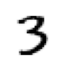

In [270]:
show_image(three_tensors[1]); # show_image is from PIL.

In [271]:
# pixel similarity => for every pixel position, average over all the images
# of the intensity of that pixel.
# combine images to a single 3d tensor, or a rank-3 tensor using stack.
stacked_sevens = torch.stack(seven_tensors).float()/255 
#casting to float to take averages.
# dividing by 255 to convert from 0-255 to 0-1.
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [272]:
len(stacked_threes.shape) #length of a tensor's shape is its rank.
# => 3 
# _rank_ is the number of axes or dimensions in a tensor;
# _shape_ is the size of each axis of a tensor.

3

In [273]:
# we can also use ndim to find tensor's rank.
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

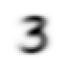

In [274]:
mean3 = stacked_threes.mean(0)
# mean(0) => [6131, 28, 28], mean using first index to iterate.
show_image(mean3);

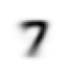

In [275]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

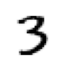

In [276]:
a_3 = stacked_threes[1]
show_image(a_3);
#take a random 3 and measure its *distance* from our ideal digits.

using L1 norm or mean absolute difference
using L2 norm or root mean squared error (RMSE)

In [277]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [278]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [279]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

**NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**<br>
A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's also a multidimensional table of data, with all items of the same type. However, the tensor has to use a single basic numeric type for all components. also, a PyTorch sensor cannot be jagged.

PyTorch also can run on GPU and automatically calculate derivatives of these operations. 

a few commands to learn how to work with array/tensor APIs.

In [280]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [281]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [282]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [283]:
tns[1] #second row.

tensor([4, 5, 6])

In [284]:
tns[:,1] #all of first axis(rows), and index 1 of second axis(column)

tensor([2, 5])

In [285]:
tns[1,1:3] #using python slice syntax.
#[start:end] => math notation=>[start,end) end is excluded.
# so here, [4,5,6], 1:3 gives 5,6 or 1,2 indexes and not 3.

tensor([5, 6])

In [286]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [287]:
tns.type()

'torch.LongTensor'

In [288]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

We made our baseline model using simple mean and measuring distance with L1 or L2 Norm loss functions. now we must see if our baseline model is any good. To QUANTIFY this we must define a metric.<br>
a metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is.<br>
we can use MSE or mean absolute error, but values are not understandable. so we instead use *accuracy* as a metric for classification models.<br>
we calculate metric over a *validation set* to not over-fit data.


In [289]:
# creating a validation set.
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

It's good to get in the habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

We ultimately want to write a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

In [290]:
# measure distance of test_image with the ideal digits of 4 and 7.
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
#mean((-1,-2)) : take mean over the last axes with pixel values, convert to one no. i.e. mnist_distance.
mnist_distance(a_3, mean3)

tensor(0.1114)

In [291]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1242, 0.1132, 0.1246,  ..., 0.1285, 0.1309, 0.1262]),
 torch.Size([1010]))

`valid_3_tens` and `mean3` rank doesn't match. The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

In [292]:
tensor([1,2,3]) + tensor(1) #simple broadcasting example.

tensor([2, 3, 4])

In [293]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`.

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

- PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

This is true of all broadcasting and elementwise operations and functions done in PyTorch. *It's the most important technique for you to know to create efficient PyTorch code.*

Next in `mnist_distance` we see `abs`. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

Finally, our function calls `mean((-1,-2))`. The tuple `(-1,-2)` represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was `(1010)`. In other words, for every image, we averaged the intensity of all the pixels in that image.

We'll be learning lots more about broadcasting throughout this book, especially in <<chapter_foundations>>, and will be practicing it regularly too.

We can use `mnist_distance` to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [294]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [295]:
is_3(a_3), is_3(a_3).float() #testing on eg a_3.

(tensor(True), tensor(1.))

In [296]:
is_3(valid_3_tens) #using broadcasting to test on full validation set.

tensor([True, True, True,  ..., True, True, True])

In [297]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

until now no real learning is being done. in *Pixel Similarity* approach, only checking two digit. now using stochastic gradient descent.

## Stochastic Gradient Descent (SGD)

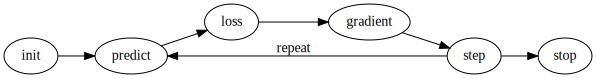

In [298]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [299]:
def f(x): return x**2

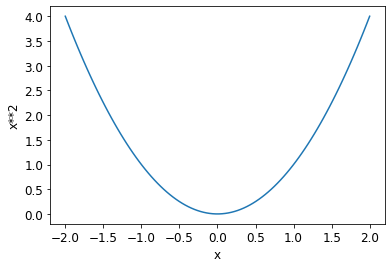

In [300]:
plot_function(f, 'x', 'x**2')

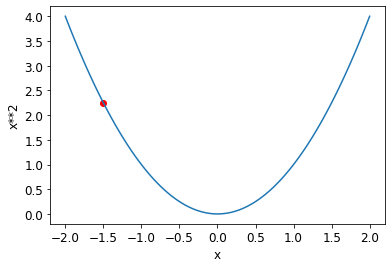

In [301]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [302]:
xt = tensor(3.).requires_grad_()

In [303]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [304]:
yt.backward() #calculate gradient of yt with rexpect to xt.
# or where for a parameter requires_grad_() is defined. 

In [305]:
xt.grad

tensor(6.)

In [306]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [307]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [308]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [309]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

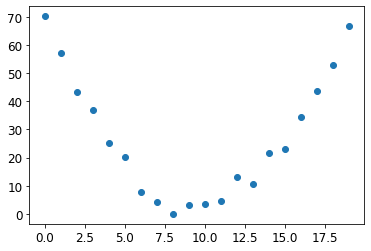

In [310]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [311]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [312]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [313]:
params = torch.randn(3).requires_grad_()

In [314]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [315]:
preds = f(time, params)

In [316]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

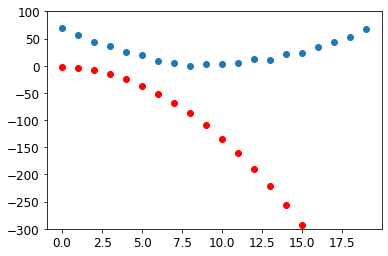

In [317]:
show_preds(preds)

#### Step 3: Calculate the loss

In [318]:
loss = mse(preds, speed)
loss

tensor(59102.5859, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [319]:
loss.backward()
params.grad

tensor([-81058.0781,  -5223.4287,   -379.8395])

In [320]:
params.grad * 1e-5

tensor([-0.8106, -0.0522, -0.0038])

In [321]:
params # params before stepping weights/params

tensor([-1.2414, -0.7704, -2.1995], requires_grad=True)

#### Step 5: Step the weights. 

In [322]:
lr = 1e-5
params.data -= lr * params.grad.data ## using params.data to change params/weights
params.grad = None ## setting params.grad to None, or else, next time params.grad will add to previous grad.

In [323]:
preds = f(time,params)
mse(preds, speed)

tensor(11762.8652, grad_fn=<MeanBackward0>)

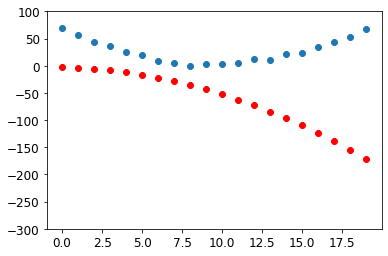

In [324]:
show_preds(preds)

In [325]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [326]:
for i in range(10): apply_step(params)
## prints loss, loss is going down

11762.865234375
2804.73974609375
1109.580322265625
788.796142578125
728.0858154296875
716.5892333984375
714.4054565429688
713.9840087890625
713.8961181640625
713.8712158203125


In [327]:
#hide
params = orig_params.detach().requires_grad_()

In [328]:
params

tensor([-1.2414, -0.7704, -2.1995], requires_grad=True)

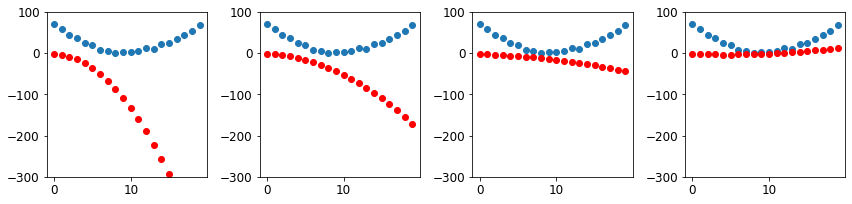

In [329]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

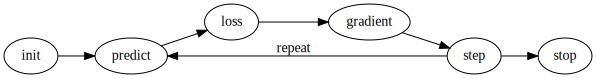

In [330]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [331]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28) 
torch.cat([stacked_threes, stacked_sevens]).shape, torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28).shape
## view(-1,28*28) converts from [12396,28,28] to [12396, 784 or (28*28)]

(torch.Size([12396, 28, 28]), torch.Size([12396, 784]))

In [332]:
tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(0).shape #
tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1), tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(0)
## testing unsqueeze, 1 means in second axis, or y axis, 0 means in x axis, here we need 1 i.e. y axis.

(tensor([[1],
         [1],
         [1],
         ...,
         [0],
         [0],
         [0]]), tensor([[1, 1, 1,  ..., 0, 0, 0]]))

In [333]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1) #defining label 
# 1 is 3, 0 is seven. as we multiply by 1 by no. of 3s, and 0 by no. of 7s.
train_x.shape,train_y.shape
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [334]:
dset = list(zip(train_x,train_y))
# Dataset in Pytorch needs to return a tuple of (x,y)
# zip function returns a tuple of (x,y)
x,y = dset[0] ## just checking first item in dataset, x-training, y is its label.
x.shape,y #y is label

(torch.Size([784]), tensor([1]))

In [335]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [336]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [337]:
weights = init_params( (28*28,1) )

In [338]:
bias = init_params(1)

In [339]:
(train_x[0]*weights).shape, (train_x[0]*weights.T).shape

(torch.Size([784, 784]), torch.Size([1, 784]))

In [340]:
(train_x[0]*weights.T).sum() + bias

tensor([2.2398], grad_fn=<AddBackward0>)

In [341]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ 2.2398],
        [ 7.0541],
        [-2.3737],
        ...,
        [12.3111],
        [14.7682],
        [ 8.9666]], grad_fn=<AddBackward0>)

In [342]:
predArr = (preds>0.0).float() 
predArr == train_y
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [343]:
corrects = ((preds>0.0).float()) == train_y
# eg. preds is 21 or -9, 
# (preds>0.0).float() == train_y #compare w/ zero
# (true).float() == train_y #turn boolean to number
# 1.0 == train_y #train_y is 0 or 1.
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [344]:
corrects.float().mean().item()

0.461197167634964

In [345]:
with torch.no_grad(): weights[0] *= 1.0001 ## no_grad(), don't calculate gradient for this step

In [346]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()
## we changed a single weight and calculated accuracy, but its almost the as before.
## using accuracy doesn't work to step weights, so we need a different loss fn.
## using accuracy as loss fn, (y_new - y_old) will almost always be 0. In other words, the gradient is 0 almost everywhere.

0.461197167634964

**finding a loss function**
we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

In [347]:
#sample_inputs.
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [348]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [349]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [350]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [351]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts) #with a different prediction, decreased loss

tensor(0.2333)

### Sigmoid

In [352]:
# signmoid fn always outputs a no. between 0 and 1.
def sigmoid(x): return 1/(1+torch.exp(-x))

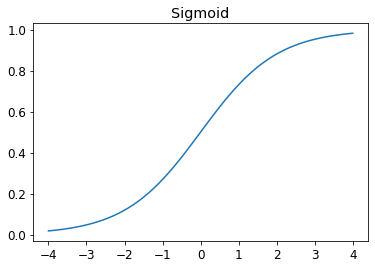

In [353]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)
#pytorch version of sigmoid fn, faster.

In [354]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() #applying sigmoid to predictions.
    ## 0,1 range is required to use with 0,1 label system.
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [355]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl) #takes a collection and turn it to mini batches.

[tensor([ 1,  8, 13,  4,  3]),
 tensor([14,  5, 11,  6,  9]),
 tensor([10,  0,  7,  2, 12])]

In [356]:
## a pytorch DataSet requires a list of tuples, eg. (1,2),(2,3).
ds = L(enumerate(string.ascii_lowercase)) ## a basic eg of list of tuples.
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [357]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
## a DataLoader creates mini-batches.
list(dl)

[(tensor([ 0, 15,  8, 11, 22, 19]), ('a', 'p', 'i', 'l', 'w', 't')),
 (tensor([ 7,  6,  2,  1, 10,  5]), ('h', 'g', 'c', 'b', 'k', 'f')),
 (tensor([25,  3,  9, 18, 14, 20]), ('z', 'd', 'j', 's', 'o', 'u')),
 (tensor([13, 16, 24, 21, 17, 23]), ('n', 'q', 'y', 'v', 'r', 'x')),
 (tensor([ 4, 12]), ('e', 'm'))]

## Putting It All Together

In [358]:
weights = init_params((28*28,1))
bias = init_params(1)

In [359]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [360]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [361]:
batch = train_x[:4] ## manually making a batch, selecting 4 items 
batch.shape

torch.Size([4, 784])

In [362]:
preds = linear1(batch)
preds

tensor([[ 1.8982],
        [ 3.5337],
        [ 0.8146],
        [14.0227]], grad_fn=<AddBackward0>)

In [363]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.1164, grad_fn=<MeanBackward0>)

In [364]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad
#see indepth 

(torch.Size([784, 1]), tensor(-0.0127), tensor([-0.0884]))

In [365]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [366]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad ## calling gradients once

(tensor(-0.0253), tensor([-0.1768]))

In [367]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad
## calling gradients again adds to the old one, so need to do weights.grad.zero_()

(tensor(-0.0380), tensor([-0.2652]))

In [368]:
weights.grad.zero_()
bias.grad.zero_();

In [369]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [370]:
(preds>0.0).float() == train_y[:4] ## checking accuracy

tensor([[True],
        [True],
        [True],
        [True]])

In [371]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [372]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(1.)

In [373]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    # accs is a list of batch accuracies tensor.
    return round(torch.stack(accs).mean().item(), 4) #round to 4.

In [374]:
validate_epoch(linear1)

0.7453

In [375]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7138

In [376]:
test1=[xb,yb in valid_dl]
test1

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), False]

In [377]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8583 0.9076 0.931 0.9423 0.9462 0.9525 0.9594 0.9613 0.9618 0.9647 0.9662 0.9667 0.9677 0.9691 0.9691 0.9701 0.9701 0.9701 0.9706 0.9701 

### Creating an Optimizer

In [378]:
linear_model = nn.Linear(28*28,1)

In [379]:
w,b = linear_model.parameters() ## nn.Linear gives parameters() fn to get parameters.
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [387]:
## creating a custom BasicOptim class to do the step part of the process. 
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr ## takes params and lr as arguments

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr ## step fn

    def zero_grad(self, *args, **kwargs): ## set grad to none/zero to clear old grad.
        for p in self.params: p.grad = None

In [381]:
opt = BasicOptim(linear_model.parameters(), lr)

In [382]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [383]:
validate_epoch(linear_model)

0.5321

In [384]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [385]:
train_model(linear_model, 20)

0.4932 0.7768 0.8564 0.917 0.936 0.9502 0.9575 0.9629 0.9663 0.9677 0.9697 0.9716 0.9736 0.9746 0.976 0.977 0.9775 0.9775 0.9785 0.9785 

In [386]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8476 0.8369 0.9116 0.934 0.9453 0.9555 0.9614 0.9653 0.9677 0.9687 0.9716 0.9731 0.9746 0.976 0.976 0.9775 0.9785 0.9785 0.979 

In [388]:
dls = DataLoaders(dl, valid_dl)

In [389]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [390]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.637458,0.503642,0.495584,00:00
1,0.601436,0.110731,0.928361,00:00
2,0.217298,0.230247,0.781649,00:00
3,0.093717,0.118839,0.901374,00:00
4,0.048101,0.083309,0.929833,00:00
5,0.030366,0.065571,0.943572,00:00
6,0.023116,0.054816,0.955839,00:00
7,0.019944,0.047749,0.961236,00:00
8,0.018381,0.042843,0.965162,00:00
9,0.017476,0.039270,0.967125,00:00


## Adding a Nonlinearity

In [391]:
## if no non-linearity between two layers, same as having one layer with more parameters.
def simple_net(xb): 
    res = xb@w1 + b1 ## layer1
    res = res.max(tensor(0.0)) ## adding ReLU or non-linearity
    ## changes no. below 0 to 0.
    res = res@w2 + b2 ## layer2
    return res

In [400]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

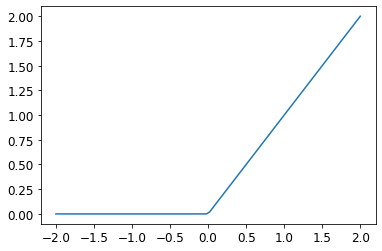

In [401]:
plot_function(F.relu)

In [394]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [395]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [396]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.292292,0.407993,0.506379,00:00
1,0.138463,0.217417,0.816977,00:00
2,0.077834,0.111837,0.917566,00:00
3,0.051946,0.076536,0.940137,00:00
4,0.039825,0.060122,0.956330,00:00
5,0.033547,0.050868,0.964671,00:00
6,0.029892,0.045021,0.966634,00:00
7,0.027497,0.041007,0.967125,00:00
8,0.025765,0.038077,0.968106,00:00
9,0.024424,0.035832,0.969578,00:00


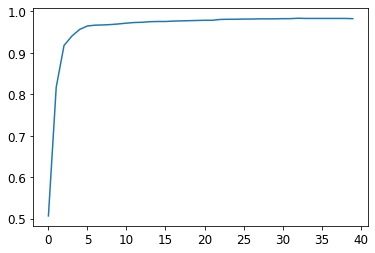

In [397]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [398]:
learn.recorder.values[-1][2]

0.98233562707901

### Going Deeper

In [399]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,0.135047,0.036506,0.992640,03:26


## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.